# 사과 종 분류 과제

## 데이터 구조

```
$ DATA/
├── train/
│   ├── xxx.jpg
│   ├── yyy.jpg
│   └── zzz.jpg
├── test/
│   ├── xxx.jpg
│   ├── yyy.jpg
│   └── zzz.jpg
├── train.csv
├── test.csv
├── sample_submission.csv
├── train_labels.csv (코드 실행 후 생성)
└── valid_labels.csv (코드 실행 후 생성)
```



## 0. 사전 준비

### 구글 드라이브 마운트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



### 데이터 압축 풀기

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/YearDream-Kaggle/1차 모의대회/CV')

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
# !unzip train.zip

In [ ]:
# !unzip test.zip

### 필요 라이브러리 설치

In [ ]:
!pip install timm
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 549 kB 28.0 MB/s 
     |████████████████████████████████| 182 kB 68.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1. 라이브러리 불러오기

In [ ]:
# # !pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"
# !pip install albumentations==0.5.2

In [ ]:
from torch.utils.data import DataLoader
import torch
import torchvision

from datetime import datetime, timezone, timedelta
import numpy as np
import random
import os
import copy

import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random

import timm
from torch import nn

# import albumentations
# from albumentations import (VerticalFlip, HorizontalFlip, Flip, RandomRotate90, Rotate, ShiftScaleRotate, CenterCrop, OpticalDistortion, GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
#                             RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise, CLAHE, ChannelShuffle, InvertImg, RandomGamma, ToGray, PadIfNeeded 
#                            )
# from albumentations.pytorch import transforms


from sklearn.metrics import accuracy_score, f1_score

## 2. 경로 / 기타 인자 설정

### 데이터 경로 설정

In [ ]:
# 프로젝트 경로
path = '/content/drive/MyDrive/Colab Notebooks/YearDream-Kaggle/1차 모의대회/CV'
os.chdir(path)

# 데이터 경로
TRAIN_IMG_DIR = os.path.join(path, 'train')
TRAIN_LABEL_DIR = os.path.join(path, 'train.csv')
TEST_IMG_DIR = os.path.join(path, 'test')
TEST_LABEL_DIR = os.path.join(path, 'test.csv')
SAMPLE_DIR = os.path.join(path, 'sample_submission.csv')

In [ ]:
# # 파일 수 확인 
# print(len(os.listdir(TRAIN_IMG_DIR)))
# print(len(os.listdir(TEST_IMG_DIR)))

### 결과 저장 경로 설정

In [ ]:
# 시간 고유값 
kst = timezone(timedelta(hours=9))        
train_serial = datetime.now(tz=kst).strftime("%Y%m%d_%H%M%S")

# 기록 경로
RECORDER_DIR = os.path.join(path, 'results', 'train', train_serial)
# 현재 시간 기준 폴더 생성
os.makedirs(RECORDER_DIR, exist_ok=True)    

### 시드 설정

In [ ]:
# 시드
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

### 디바이스 설정

In [ ]:
# GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 3. 데이터 불러오기 및 분할

### Train 라벨

In [ ]:
# 학습 파일
traindf = pd.read_csv(TRAIN_LABEL_DIR)

traindf.head()

,img_id,a_type
0,yVvIyEOqz8.jpg,HJ
1,HLdFN3ULg2.jpg,HJ
2,bAm1CUZtO8.jpg,HJ
3,n5hMUvCCV6.jpg,HR
4,9RiwdmWGSq.jpg,SG


In [ ]:
len(traindf)

10000

In [ ]:
traindf.a_type.value_counts()

HJ    5325
HR    3049
SG     817
AR     809
Name: a_type, dtype: int64

In [ ]:
traindf.shape

(10000, 2)

### Train 이미지 예시

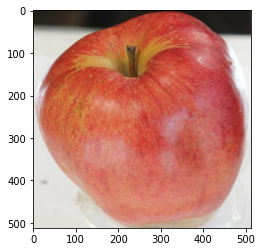

In [ ]:
# 이미지 예시
example_index = random.randrange(len(traindf)) # 0,1,2,...
example_imageid = traindf['img_id'][example_index]
example_image_path = os.path.join(TRAIN_IMG_DIR, example_imageid)
example_image = Image.open(example_image_path)

plt.imshow(example_image)

### Train / Validation 분할

#### weight sample 


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

weightss = compute_class_weight('balanced', classes=np.unique(traindf['a_type']), y=traindf["a_type"])
weightss = torch.FloatTensor(weightss).to(device)
weightss

tensor([3.0902, 0.4695, 0.8199, 3.0600])

In [ ]:
# 80% / 20% 비율로 분할
train,val = train_test_split(traindf, test_size=0.2, shuffle=True)

# train / validation로 나눈 데이터 프레임 저장
train.to_csv(os.path.join(path, 'train_labels.csv'), index=False)
val.to_csv(os.path.join(path, 'val_labels.csv'),index=False)

## 4. Dataset 

### Dataset 클래스 정의

In [ ]:
class AppleDataset(Dataset):
  def __init__(self, img_folder, labelpath):
    self.df = pd.read_csv(labelpath, usecols=['img_id','a_type'],dtype={'a_type':str})
    self.label_encoding = {'HJ':0, 'HR':1, 'SG':2, 'AR':3}
    self.img_folder = img_folder
    self.transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.PILToTensor(),
        transforms.ConvertImageDtype(torch.float),        
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
        transforms.RandomErasing()
    ])  
    self.img_ids = list(self.df['img_id'])
    self.labels = list(self.df['a_type'])
  
  def __len__(self):
    return len(self.img_ids)

  def __getitem__(self, index):
    impath = os.path.join(self.img_folder, self.img_ids[index])
    img = Image.open(impath)
    img = self.transforms(img)
    lbl = self.labels[index]
    lbl = self.label_encoding[lbl]
    return img,lbl


## 5. 모델 정의

### 모델 Class 생성

In [ ]:
# !pip install pytorch-ignite

In [ ]:
avail_pretrained_models = timm.list_models(pretrained=True)
avail_pretrained_models

In [ ]:
from torch.optim import optimizer
from torch.nn.modules.dropout import Dropout
F = nn.functional
num_classes = 4
class Effnet(nn.Module):
  def __init__(self):
    super(Effnet, self).__init__()
    self.model = timm.create_model('efficientnet_b4', pretrained=True)
    
    self.model.classifier = nn.Sequential(
        nn.Linear(in_features = 1792, out_features = 625),
        nn.ReLU(),
        nn.Dropout(p=0.2),
        nn.Linear(625,256),
        nn.ReLU(),
        nn.Linear(256, 4)
    )

    
  def forward(self, x):
    output = self.model(x)
    return output

class RegNet(nn.Module):
  def __init__(self):
    super(RegNet, self).__init__()
    self.model = timm.create_model('regnety_040', pretrained=True)
    
    self.model.classifier = nn.Sequential(
        nn.Linear(in_features = 1280, out_features = 4)
    )

    
  def forward(self, x):
    output = self.model(x)
    return output

class RexNet(nn.Module):
  def __init__(self):
    super(RexNet, self).__init__()
    self.model = timm.create_model('rexnet_100', pretrained=True)
    
    self.model.classifier = nn.Sequential(
        nn.Linear(in_features = 1280, out_features = 4)
    )

    
  def forward(self, x):
    output = self.model(x)
    return output

In [ ]:

num_classes = 4

class EnsembleModel(nn.Module):
    def __init__(self, modelA, modelB, modelC):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.classifier = nn.Linear(2004, num_classes)

        
    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x3 = self.modelC(x)
        x = torch.cat((x1, x2, x3), dim=1)
        x = self.classifier(F.relu(x))
        return x



### 모델 선택 함수

In [ ]:
modelA = Effnet()
modelB = RegNet()
modelC = RexNet()

modelA.to(device)
modelB.to(device)
modelC.to(device)


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b4_ra2_320-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_ra2_320-7eb33cd5.pth
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-tpu-weights/regnety_040_ra3-670e1166.pth" to /root/.cache/torch/hub/checkpoints/regnety_040_ra3-670e1166.pth
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rexnet/rexnetv1_100-1b4dddf4.pth" to /root/.cache/torch/hub/checkpoints/rexnetv1_100-1b4dddf4.pth


RexNet(
  (model): ReXNetV1(
    (stem): ConvNormAct(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
    )
    (features): Sequential(
      (0): LinearBottleneck(
        (conv_dw): ConvNormAct(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Identity()
          )
        )
        (act_dw): ReLU6()
        (conv_pwl): ConvNormAct(
          (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
      

In [ ]:
modelA.eval()
modelB.eval()
modelC.eval()

RexNet(
  (model): ReXNetV1(
    (stem): ConvNormAct(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
    )
    (features): Sequential(
      (0): LinearBottleneck(
        (conv_dw): ConvNormAct(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): Identity()
          )
        )
        (act_dw): ReLU6()
        (conv_pwl): ConvNormAct(
          (conv): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
      

In [ ]:
enmodel = EnsembleModel(modelA, modelB, modelC)
enmodel.to(device)

EnsembleModel(
  (modelA): Effnet(
    (model): EfficientNet(
      (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (bn1): BatchNormAct2d(
              48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid(

## 6. 학습

### DataLoader 관련 인자 설정

In [ ]:
# Dataloader 관련 인자
BATCH_SIZE = 16
NUM_WORKERS = 1
SHUFFLE = True
PIN_MEMORY = True
DROP_LAST = False

In [ ]:
# 데이터 셋 정의
train_dataset = AppleDataset(img_folder = TRAIN_IMG_DIR, labelpath = os.path.join(path,'train_labels.csv'))
valid_dataset = AppleDataset(img_folder = TRAIN_IMG_DIR, labelpath = os.path.join(path,'val_labels.csv'))

# 데이터 로더 정의

train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = SHUFFLE,
                              pin_memory = PIN_MEMORY,
                              drop_last = DROP_LAST)

valid_dataloader = DataLoader(dataset = valid_dataset,
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = SHUFFLE,
                              pin_memory = PIN_MEMORY,
                              drop_last = DROP_LAST)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Hyperparameter 설정
LEARNING_RATE = 0.001
EPOCHS = 10

In [ ]:
# Loss와 optimizer 설정
criterion = nn.CrossEntropyLoss(weight=weightss)
optimizer = torch.optim.AdamW(enmodel.parameters(), lr = LEARNING_RATE)

In [ ]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

In [ ]:
best_loss = np.Inf

for epoch in range(EPOCHS):
  ### 학습 ###
  enmodel.train()  # 모델 학습 적용
  
  train_total_loss = 0
  target_list = [] # 실제 사과 종 추가할 리스트 
  pred_list = []  # 예측 사과 종 추가할 리스트
  
  # train
  for batch_index, (x,y) in tqdm(enumerate(train_dataloader)):
    x,y = x.to(device), y.to(device)                          # x - image data, y - 실제 label을 GPU로 옮김 
    y_pred = enmodel(x)                                         # 모델을 통해 나온 output
    loss = criterion(y_pred, y)                               # 실제값 y와 예측값 y_pred로 loss 계산
    optimizer.zero_grad()                                     # optimizer 초기화
    loss.backward()                                           # gradient 계산
    optimizer.step()                                          # 역전파
    train_total_loss += loss.item()                           # train_total_loss에 loss값을 누적
    pred_list.extend(y_pred.argmax(dim=1).cpu().tolist())     # 예측한 값중 가장 높은 값의 인덱스를 추가
    target_list.extend(y.cpu().tolist())                      # 실제 label 인덱스를 추가 
  train_mean_loss = train_total_loss / batch_index            # 에폭의 평균 loss
  train_accuracy = accuracy_score(target_list, pred_list)     # accuracy_score
  train_f1score = f1_score(target_list, pred_list, average='macro')  # macro - f1 Score
  
  ### 검증 ###
  enmodel.eval()                                                # 학습 모드를 검증 모드로 변경
  val_total_loss = 0                                          
  target_list = []                                            
  pred_list = []
  with torch.no_grad():                                       # 역전파 하지 않음
    for batch_index, (x,y) in tqdm(enumerate(valid_dataloader)):    
      x = x.to(device)                                         
      y = y.to(device)
      y_pred = enmodel(x)
      loss = criterion(y_pred, y)
      #
      val_total_loss += loss.item()
      target_list.extend(y.cpu().tolist())
      pred_list.extend(y_pred.argmax(dim=1).cpu().tolist())
  val_mean_loss = val_total_loss / batch_index
  val_accuracy = accuracy_score(target_list, pred_list)
  val_f1score = f1_score(target_list, pred_list, average='macro')

  msg1 = f"Epoch {epoch}/{EPOCHS} - Train loss: {train_mean_loss}; Train Accuracy: {train_accuracy}; Train F1: {train_f1score}"
  msg2 = f"Valid loss: {val_mean_loss}; Val Accuracy: {val_accuracy}; Val F1: {val_f1score}"
  print(msg1)
  print(msg2)

  ### 결과 저장 ###
  # validation loss가 개선될 때 모델 저장
  if val_mean_loss < best_loss:                               
    best_loss = val_mean_loss
    check_point = {                                         
        'enmodel': enmodel.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(check_point, os.path.join(RECORDER_DIR,'best.pt')) 


## 7. 추론

### 데이터 셋 설정

In [ ]:
class TestDataset(Dataset):
  def __init__(self, img_folder, labelpath):
    self.df = pd.read_csv(labelpath , usecols=['img_id'],dtype={'img_id':str})
    self.img_folder = img_folder
    self.transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
    self.img_ids = list(self.df['img_id'])
      
  def __len__(self):
    return len(self.img_ids)
  
  def __getitem__(self, index):
    impath = os.path.join(self.img_folder, self.img_ids[index])
    img = Image.open(impath)
    img = self.transforms(img)
    img_ids = self.img_ids[index]
    
    return img,img_ids

### Dataset 및 DataLoader 설정

In [ ]:
# Dataloader 관련 인자
BATCH_SIZE = 1
NUM_WORKERS = 1
SHUFFLE = False
PIN_MEMORY = True
DROP_LAST = False

In [ ]:
# Dataset
test_dataset = TestDataset(img_folder = TEST_IMG_DIR, labelpath = os.path.join(TEST_LABEL_DIR))


# DataLoader
test_dataloader = DataLoader(dataset = test_dataset,
                              batch_size = BATCH_SIZE,
                              num_workers = NUM_WORKERS,
                              shuffle = SHUFFLE,
                              pin_memory = PIN_MEMORY,
                              drop_last = DROP_LAST)

### 추론 진행

In [ ]:
enmodel.eval()      # 학습 모드를 검증 모드로 변경

# 예측 진행
y_preds = []
img_ids = []

for batch_index, (x, img_id) in enumerate(tqdm(test_dataloader)):
    x = x.to(device, dtype=torch.float)
    y_logits = enmodel(x).cpu()
    y_pred = torch.argmax(y_logits, dim=1)
    y_pred = y_pred.cpu().tolist()
    img_ids.extend(img_id)
    y_preds.extend(y_pred)

### 추론 결과 저장

In [ ]:
# 결과 데이터 프레임 생성 및 라벨 디코딩
pred_df = pd.DataFrame(list(zip(img_ids, y_preds)), columns=['img_id','a_type'])
label_decoding = {0:'HJ', 1:'HR', 2:'SG', 3:'AR'}
pred_df['a_type'] = pred_df['a_type'].replace(label_decoding)

In [ ]:
# 샘플과 동일한 순서로 변경
sample_df = pd.read_csv(SAMPLE_DIR)
sorter = list(sample_df['img_id'])
resdf = pred_df.set_index('img_id')
result = resdf.loc[sorter].reset_index()

In [ ]:
result

In [ ]:
result.to_csv(os.path.join(RECORDER_DIR,'result22.csv'),index=False)